# Single-View Geometry (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the *Single-View Geometry* section of Assignment 3. In [main function](#Main-function), we outline the required functionalities step by step. Some of the functions which involves interactive plots are already provided, but [the rest](#Your-implementation) are left for you to implement.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- In this code, we use `tkinter` package. Installation instruction can be found [here](https://anaconda.org/anaconda/tk).

# Common imports

In [ ]:
######
#@title 1. Connect Colab to your google drive
######

%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')
#### change to the directory in your drive.
%cd "/content/drive/MyDrive/MP3/Q3"

Mounted at /content/drive
/content/drive/MyDrive/MP3/Q3


In [ ]:
import matplotlib
#matplotlib.use('Agg') # or 'SVG'
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from PIL import Image
import pickle

In [ ]:
!apt-get install -y python3-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-tk is already the newest version (3.8.10-0ubuntu1~20.04).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
# %matplotlib inline
#% matplotlib tk
#% matplotlib.use('tk')

# Provided functions

In [ ]:
def get_input_lines(im, min_lines=3):
    """
    Allows user to input line segments; computes centers and directions.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        min_lines: minimum number of lines required
    Returns:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    """
    n = 0
    lines = np.zeros((3, 0))
    centers = np.zeros((3, 0))

    plt.figure()
    plt.axis('off')
    plt.imshow(im)
    print(f'Set at least {min_lines} lines to compute vanishing point')
    print(f'The delete and backspace keys act like right clicking')
    print(f'The enter key acts like middle clicking')
    while True:
        print('Click the two endpoints, use the right button (delete and backspace keys) to undo, and use the middle button to stop input')
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        if not clicked or len(clicked) < 2:
            if n < min_lines:
                print(f'Need at least {min_lines} lines, you have {n} now')
                continue
            else:
                # Stop getting lines if number of lines is enough
                break

        # Unpack user inputs and save as homogeneous coordinates
        pt1 = np.array([clicked[0][0], clicked[0][1], 1])
        pt2 = np.array([clicked[1][0], clicked[1][1], 1])
        # Get line equation using cross product
        # Line equation: line[0] * x + line[1] * y + line[2] = 0
        line = np.cross(pt1, pt2)
        lines = np.append(lines, line.reshape((3, 1)), axis=1)
        # Get center coordinate of the line segment
        center = (pt1 + pt2) / 2
        centers = np.append(centers, center.reshape((3, 1)), axis=1)

        # Plot line segment
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')

        n += 1

    return n, lines, centers

In [ ]:
def plot_lines_and_vp(ax, im, lines, vp):
    """
    Plots user-input lines and the calculated vanishing point.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        vp: np.ndarray of shape (3, )
    """
    bx1 = min(1, vp[0] / vp[2]) - 10
    bx2 = max(im.shape[1], vp[0] / vp[2]) + 10
    by1 = min(1, vp[1] / vp[2]) - 10
    by2 = max(im.shape[0], vp[1] / vp[2]) + 10

    ax.imshow(im)
    for i in range(lines.shape[1]):
        if lines[0, i] < lines[1, i]:
            pt1 = np.cross(np.array([1, 0, -bx1]), lines[:, i])
            pt2 = np.cross(np.array([1, 0, -bx2]), lines[:, i])
        else:
            pt1 = np.cross(np.array([0, 1, -by1]), lines[:, i])
            pt2 = np.cross(np.array([0, 1, -by2]), lines[:, i])
        pt1 = pt1 / pt1[2]
        pt2 = pt2 / pt2[2]
        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')

    ax.plot(vp[0] / vp[2], vp[1] / vp[2], 'ro')
    ax.set_xlim([bx1, bx2])
    ax.set_ylim([by2, by1])

# Your implementation

In [ ]:
def get_vanishing_point(n, lines):
    """
    Solves for the vanishing point using the user-input lines.
    """
    # <YOUR CODE>
    M = np.zeros((3, 3))
    for i in range(n):
        M += lines[:, i:i+1] @ lines[:, i:i+1].T
    val, vec = np.linalg.eig(M)
    vp = vec[:, np.argmin(val)]
    vp /= vp[-1]
    return vp

In [ ]:
def get_horizon_line(vp1, vp2):
    """
    Calculates the ground horizon line.
    """
    # <YOUR CODE>
    def symbol(num):
        if num < 0:
            return f'{num}'
        else:
            return f'+ {num}'
    dirn = np.cross(vp1, vp2)
    dirn = dirn / np.linalg.norm(dirn[:2])
    print(f'Horizon line equation is: {symbol(dirn[0])}x {symbol(dirn[1])}y {symbol(dirn[2])} = 0')
    return dirn



In [ ]:
def plot_horizon_line(vp1, vp2, im, ax):
    """
    Plots the horizon line.
    """
    # <YOUR CODE>
    pt1 = (vp1 / vp1[-1])[:2]
    pt2 = (vp2 / vp2[-1])[:2]
    ax.imshow(im)
    ax.axline(pt1, pt2, c='g')
    ax.plot(pt1[0], pt1[1], 'ro')
    ax.plot(pt2[0], pt2[1], 'ro')

In [ ]:
def get_camera_parameters(vpts):
    """
    Computes the camera parameters. Hint: The SymPy package is suitable for this.
    """
    # <YOUR CODE>
    vpts /= vpts[-1, :]
    vp1 = vpts[:, 0]
    vp2 = vpts[:, 1]
    vp3 = vpts[:, 2]
    A = np.zeros((3, 3))
    A[0, :] = vp1 + vp2
    A[1, :] = vp1 + vp3
    A[2, :] = vp2 + vp3
    b = np.zeros((3, ))
    b[0] = vp1 @ vp2
    b[1] = vp1 @ vp3
    b[2] = vp2 @ vp3
    b -= 1
    px, py, k = np.linalg.inv(A) @ b
    f = -2 * k - px**2 - py**2
    return f, px, py, np.array([[f, 0, px], [0, f, py], [0, 0, 1]])

In [ ]:
def get_rotation_matrix(vpts, K):
    """
    Computes the rotation matrix using the camera parameters.
    """
    # <YOUR CODE>
    R = np.zeros((3, 3))
    Kinv = np.linalg.inv(K)
    for i in range(3):
        ri = Kinv @ vpts[:, i]
        R[:, i] = ri / np.linalg.norm(ri)
    return R

In [ ]:
def get_homography(R, K):
    """
    Compute homography for transforming the image into fronto-parallel
    views along the different axes.
    """
    # <YOUR CODE>
    return K @ R @ np.linalg.inv(K)

# Main function

In [ ]:
im = np.asarray(Image.open('./eceb.jpg'))

# Also loads the vanishing line data if it exists in data.pickle file.
# data.pickle is written using snippet in the next cell.
if os.path.exists('./data.pickle'):
    with open('./data.pickle', 'rb') as f:
        all_n, all_lines, all_centers = pickle.load(f)
    num_vpts = 3

In [ ]:
# # Click and save the line data for vanishing points. This snippet
# # opens up an interface for selecting points and writes them to
# # data.pickle file. The file is over-written.

# num_vpts = 3
# all_n, all_lines, all_centers = [], [], []

# for i in range(num_vpts):
#     print(f'Getting vanishing point {i}')

#     # Get at least three lines from user input
#     n_i, lines_i, centers_i = get_input_lines(im)
#     all_n.append(n_i)
#     all_lines.append(lines_i)
#     all_centers.append(centers_i)

# with open('data.pickle', 'wb') as f:
#     pickle.dump([all_n, all_lines, all_centers], f)

Vanishing point 1: [-1.91080224e+03  9.38131166e+01  1.00000000e+00]
Vanishing point 2: [ 3.67966328e+03 -1.05848093e+02  1.00000000e+00]
Vanishing point 3: [2.17582618e+03 5.63670907e+03 1.00000000e+00]


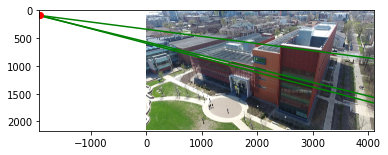

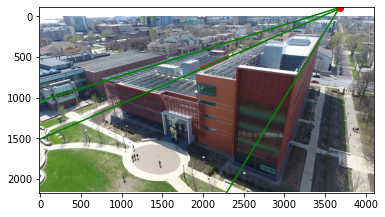

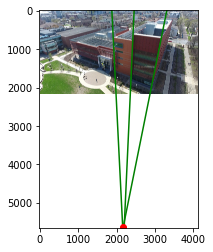

In [ ]:
# Part (1)
# Computing vanishing points for each of the directions
vpts = np.zeros((3, num_vpts))

for i in range(num_vpts):
    fig = plt.figure(); ax = fig.gca()

    # <YOUR CODE> Solve for vanishing point
    vpts[:, i] = get_vanishing_point(all_n[i], all_lines[i])
    print("Vanishing point {}: {}".format(i+1,vpts[:, i]))
    # Plot the lines and the vanishing point
    plot_lines_and_vp(ax, im, all_lines[i], vpts[:, i])
    fig.savefig('Q3_vp{:d}.pdf'.format(i), bbox_inches='tight')

Horizon line equation is: + 0.035691838716190465x + 0.9993628433402242y -25.553297519352334 = 0


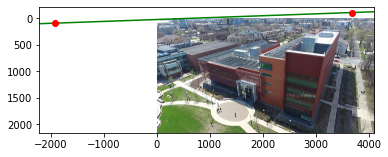

In [ ]:
# Part (2) Computing and plotting the horizon
# <YOUR CODE> Get the ground horizon line
horizon_line = get_horizon_line(vpts[:, 0], vpts[:, 1])

# <YOUR CODE> Plot the ground horizon line
fig = plt.figure(); ax = fig.gca()
plot_horizon_line(vpts[:, 0], vpts[:, 1], im, ax)
fig.savefig('Q3_horizon.pdf', bbox_inches='tight')

In [ ]:
# Part (3) Computing Camera Parameters
# <YOUR CODE> Solve for the camera parameters (f, u, v)
f, u, v, K = get_camera_parameters(vpts)
print(u, v, f, K)

2014.5771455646786 1121.7752244949875 5274144.542219853 [[5.27414454e+06 0.00000000e+00 2.01457715e+03]
 [0.00000000e+00 5.27414454e+06 1.12177522e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [ ]:
# Part (4) Computing Rotation Matrices
# <YOUR CODE> Solve for the rotation matrix
R = get_rotation_matrix(vpts, K)
print(R)

[[-7.44268231e-04  3.15707314e-04  3.05734838e-05]
 [-1.94905884e-04 -2.32762529e-04  8.56050144e-04]
 [ 9.99999704e-01  9.99999923e-01  9.99999633e-01]]


In [ ]:
homo = get_homography(R, K)

In [ ]:
np.linalg.inv(homo)

array([[-9.52312302e+02, -2.49036789e+02,  3.47782854e+06],
       [ 9.19220696e+02, -6.77514367e+02,  1.82000870e+06],
       [ 6.27800323e-06,  1.75782571e-04, -4.49468815e-03]])

In [ ]:
get_homography(np.linalg.inv(R), K)

array([[-9.52312302e+02, -2.49036789e+02,  3.47782854e+06],
       [ 9.19220696e+02, -6.77514367e+02,  1.82000870e+06],
       [ 6.27800323e-06,  1.75782571e-04, -4.49468815e-03]])